# Encoding using multiple harmonics gives worse noise resilience in the worst case than using just one

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
plt.style.use('seaborn-v0_8-notebook')
np.random.seed(7) # seed so plots are repeatable
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [8,6]) # paper figures should be width 8 (full linewidth) to have nicely readable text

In [2]:
N = 8
neuron_indices = np.atleast_2d(np.arange(N)).T

activity = lambda theta, fs, scaled: np.sum([np.cos(-theta*(f if scaled else 1) + 2*np.pi*f*neuron_indices/N) for f in fs], axis=0)

neuron_index_to_xy = lambda index: (np.cos(2*np.pi*index/N), np.sin(2*np.pi*index/N))
cos_sin = lambda x: (np.cos(x), np.sin(x))

# for a particular harmonic -> output activity with that harmonic
harmonic_encoder = lambda f: lambda r, theta: r*activity(theta, [f], True)

# decode activity with a particular harmonic into either (X,Y) position, angle, or distance
# For higher harmonics, output all f possible decodings for the all_ decoders
get_psuedo_inv_T = lambda f: np.linalg.pinv(np.hstack(neuron_index_to_xy(f*neuron_indices)))
decoder = lambda f: (lambda pseudo_inv_T: lambda a: (pseudo_inv_T @ a)) (get_psuedo_inv_T(f))
decoding_to_angle = lambda decoding, f: 1/f*np.arctan2(*decoding[::-1,:])
decoding_to_distance = lambda decoding: np.sqrt(np.sum(decoding**2, axis=0))
first_angle_decoder = lambda f: (lambda decode: lambda a: decoding_to_angle(decode(a), f)) (decoder(f))
distance_decoder = lambda f: (lambda decode: lambda a: decoding_to_distance(decode(a))) (decoder(f))
first_xy_decoder = lambda f: (lambda first_angle_decoder, distance_decoder: lambda a: distance_decoder(a)*cos_sin(first_angle_decoder(a))) (first_angle_decoder(f), distance_decoder(f))
all_angles_decoder = lambda f: (lambda decode: lambda a: 2*np.pi/f*np.atleast_2d(np.arange(f)).T + decoding_to_angle(decode(a), f)) (decoder(f))
all_xy_decoder = lambda f: (lambda all_angles_decoder, distance_decoder: lambda a: distance_decoder(a)*cos_sin(all_angles_decoder(a))) (all_angles_decoder(f), distance_decoder(f))

# create the 2D likelihood distribution for a certain harmonic from some activity
grid_x, grid_y = np.meshgrid(np.arange(-2.5,2.5,0.025), np.arange(0-2.5,2.5,0.025))
sigma = 0.5
gaussian2d = lambda x, y, sigma, mu_x, mu_y: 1/(2*np.pi*sigma**2) * np.exp(-((x-mu_x)**2 + (y - mu_y)**2) / sigma**2)
likelihood_distribution = lambda f: lambda a: np.mean(np.dstack([gaussian2d(grid_x, grid_y, sigma, *xy.ravel()) for xy in all_xy_decoder(f)(a)[:,:,0].T]), axis=2)

def decode_likelihood_xy(likelihood_distribution):
    max_index = np.argmax(likelihood_distribution)
    return grid_x.ravel()[max_index], grid_y.ravel()[max_index]

def decode_multi_likelihood_xy(f, likelihood_distribution):
    likelihood_distribution = likelihood_distribution.copy()
    peaks = []
    for _ in range(f):
        max_index = np.argmax(likelihood_distribution)
        peaks.append([grid_x.ravel()[max_index], grid_y.ravel()[max_index]])
        likelihood_distribution.ravel()[:][max_index] = 0
    return np.array(peaks)

def decode_likelihood_theta(likelihood_distribution):
    max_index = np.argmax(likelihood_distribution)
    return np.arctan2(grid_y.ravel()[max_index], grid_x.ravel()[max_index])

def plot_likelihood_distribution(likelihood_distribution):
    # plt.pcolormesh(grid_x, grid_y, likelihood_distribution, shading='gouraud', cmap='Blues')
    plt.contourf(grid_x, grid_y, likelihood_distribution, cmap='Blues', alpha=0.8)

## An example of the fragility of encoding using multiple harmonics

If we encode with multiple harmonics (eg. $f=1$ and $f=2$) the second frequency encodes 2 representations $180^\circ$ apart. This ambiguity can only be resolved by choosing the representation closest to that encoded by $f=1$. But if this is sufficiently corrupted with noise the decoding of the second harmonic will be wrong.

An example is shown below -- we have a likelihood distribution centred around each of the encoded bumps for each harmonic, then the overall decoding is the maximum of the joint likelihood.

encoded xy = [1.0,0.0]
decoded xy = [-0.6750000000000065,-0.050000000000008704]


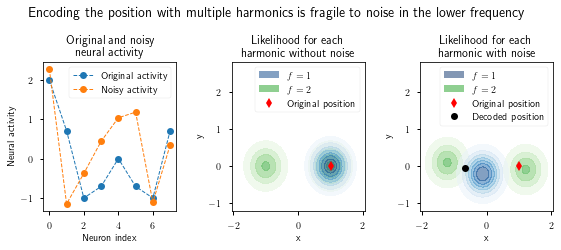

In [3]:
np.random.seed(17) # a nice example

fig, axs = plt.subplots(1, 3, figsize=(8,3.5))

r0 = 1
theta0 = 0

a0 = r0 * activity(theta0, [1,2], True)
a = a0 + np.random.randn(*a0.shape)
f1_L = likelihood_distribution(1)(a)
f2_L = likelihood_distribution(2)(a)
decode_x, decode_y = decode_likelihood_xy(f1_L*f2_L)

plt.sca(axs[0])
plt.plot(a0, 'o--', lw=1, label='Original activity')
plt.plot(a, 'o--', lw=1, label='Noisy activity')
plt.legend()
plt.xlabel('Neuron index')
plt.ylabel('Neural activity')
plt.title('Original and noisy\nneural activity')

plt.sca(axs[1])
c2 = plt.contourf(grid_x, grid_y, likelihood_distribution(2)(a0), levels=np.linspace(0.05, likelihood_distribution(1)(a0).max(), 8), cmap='Greens', alpha=0.8)
c1 = plt.contourf(grid_x, grid_y, likelihood_distribution(1)(a0), levels=np.linspace(0.05, likelihood_distribution(1)(a0).max(), 8), cmap='Blues', alpha=0.5)
r1 = plt.Rectangle((0, 0), 1, 1, fc=c1.tcolors[np.count_nonzero(c1.levels <= f1_L.max()) - 1][0], label='$f=1$')
r2 = plt.Rectangle((0, 0), 1, 1, fc=c2.tcolors[np.count_nonzero(c2.levels <= f2_L.max()) - 1][0], label='$f=2$')
plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
plt.legend(handles=[r1, r2] + axs[1].patches + axs[1].lines)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-2.05,2.05)
plt.ylim(-1.2,2.8)
plt.title('Likelihood for each\nharmonic without noise')

plt.sca(axs[2])
c2 = plt.contourf(grid_x, grid_y, f2_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
c1 = plt.contourf(grid_x, grid_y, f1_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
r1 = plt.Rectangle((0, 0), 1, 1, fc=c1.tcolors[np.count_nonzero(c1.levels <= f1_L.max()) - 1][0], label='$f=1$')
r2 = plt.Rectangle((0, 0), 1, 1, fc=c2.tcolors[np.count_nonzero(c2.levels <= f2_L.max()) - 1][0], label='$f=2$')
plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
plt.legend(handles=[r1, r2] + axs[2].patches + axs[2].lines)
# plt.legend(handles=[r1, r2, r3] + axs[2].patches + axs[2].lines)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-2.05,2.05)
plt.ylim(-1.2,2.8)
plt.title('Likelihood for each\nharmonic with noise')

print(f'encoded xy = [{r0*np.cos(theta0)},{r0*np.sin(theta0)}]')
print(f'decoded xy = [{decode_x},{decode_y}]')

plt.suptitle(f'Encoding the position with multiple harmonics is fragile to noise in the lower frequency', fontsize=14)
plt.tight_layout()
plt.savefig('plots/combined-harmonics-error-snapping-example.pdf')
plt.show()

## Noise affects the angle decoding for higher harmonics in a nonlinear way

Adding noise to a harmonic that isn't $f=1$ moves the decoded position in a nonlinear way (because the encoding is nonlinear for higher frequencies so they rotate at the same speed as the $f=1$ bump)

The encoding multiplies the encoded angle by the harmonic like:

$$\begin{aligned}
	a_n(\|\vec{p}\|, \theta_{\vec{p}}) &= \|\vec{p}\| \sum_{f \in \mathbf{F}} \cos\left(\frac{2\pi f n}{N} - f\theta_{\vec{p}}\right) \\
	&= \|\vec{p}\| \sum_{f \in \mathbf{F}} \cos\left(\frac{2\pi f n}{N}\right)\cos\left(f\theta_{\vec{p}}\right) + \sin\left(\frac{2\pi f n}{N}\right)\sin\left(f\theta_{\vec{p}}\right)
\end{aligned}$$

This projects the scaled encoded angle onto the preferred direction of each neuron, $n$. Noise can then affect the neural activity, which is modelled as zero mean Gaussian noise $\epsilon$.

$$\mathbf{a} + \epsilon$$

This noise affects each neuron independently, so corresponds to adding 2D Gaussian noise to the encoded position.

When the position is decoded for higher harmonics, the angle scaling needs to be reversed. This has the effect of rotationally compressing the Gaussian noise distribution. If the noise caused the encoded angle to be corrupted as follows:

$$\theta_{\vec{p}} \rightarrow f\theta_{\vec{p}} + \epsilon_\theta$$

Which results in the following decoded angle $\hat\theta$

$$\hat\theta = \theta_{\vec{p}} + \frac{\epsilon_\theta}{f}$$

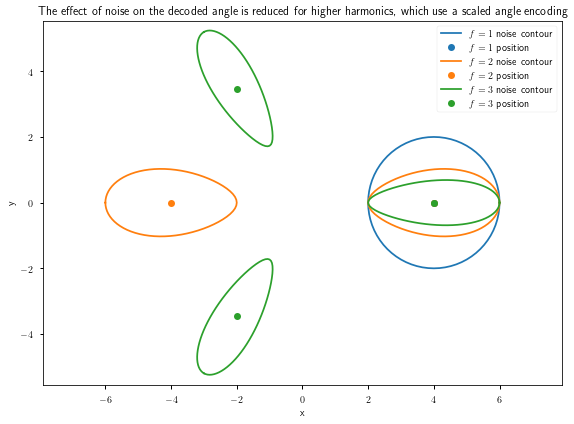

In [27]:
a0 = 4 * activity(0, [1,2,3], True)

noise_mag = 2
noise_angle_range = np.hstack((np.arange(-180, 180, 5), [-180]))

for f in [1,2,3]:
	points = np.dstack([all_xy_decoder(f)(a0 - noise_mag*np.cos(2*f*np.pi*neuron_indices/N - np.radians(noise_angle))) for noise_angle in noise_angle_range])
	plt.plot(points[0].T, points[1].T, f'C{f-1}', label=f'$f={f}$ noise contour')
	plt.plot(*all_xy_decoder(f)(a0), f'C{f-1}o', label=f'$f={f}$ position')
	
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=[handles[0], handles[1], handles[2],handles[4],handles[5],handles[8]])
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('The effect of noise on the decoded angle is reduced for higher harmonics, which use a scaled angle encoding')
plt.tight_layout()
plt.show()

## Position decoding

### $f=1$ and $f=2$
Here the decoded position jumps to the wrong $f=2$ bump when the first harmonic crosses the origin, a distance of $1r$ from original bump location

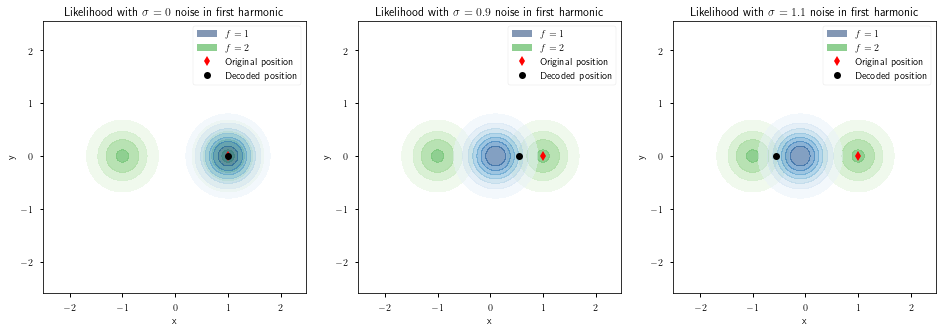

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))

a0 = r0 * activity(theta0, [1,2], True)

for noise, ax in zip([0, 0.9, 1.1], axs):
	a = a0 - noise*np.cos(2*np.pi*neuron_indices/N)
	f1_L = likelihood_distribution(1)(a)
	f2_L = likelihood_distribution(2)(a)
	decode_x, decode_y = decode_likelihood_xy(f1_L*f2_L)
	plt.sca(ax)
	# plot_likelihood_distribution(f1_L + f2_L)
	c2 = plt.contourf(grid_x, grid_y, f2_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	c1 = plt.contourf(grid_x, grid_y, f1_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	r1 = plt.Rectangle((0, 0), 1, 1, fc=c1.tcolors[np.count_nonzero(c1.levels <= f1_L.max()) - 1][0], label='$f=1$')
	r2 = plt.Rectangle((0, 0), 1, 1, fc=c2.tcolors[np.count_nonzero(c2.levels <= f2_L.max()) - 1][0], label='$f=2$')
	plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
	plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.legend(handles=[r1, r2] + ax.patches + ax.lines)
	plt.title(f'Likelihood with $\\sigma={noise}$ noise in first harmonic')
	plt.axis('equal')
# plt.tight_layout()
plt.show()

### $f=1$ and $f=3$
Now the decoded position jumps to the wrong $f=3$ bump when the first harmonic is closer to either of the other bumps, a distance of $\sin(60^\circ)r = 0.866r$ from original bump location.

The direction is $\frac{5\pi}{6}$ from the origin

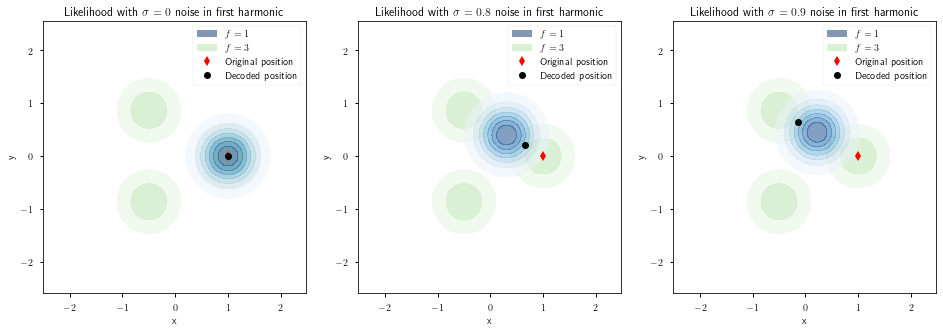

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))

a0 = r0 * activity(theta0, [1,3], True)

for noise, ax in zip([0, 0.8, 0.9], axs):
	a = a0 + noise*np.cos(2*np.pi*neuron_indices/N - 5*np.pi/6)
	f1_L = likelihood_distribution(1)(a)
	f3_L = likelihood_distribution(3)(a)
	decode_x, decode_y = decode_likelihood_xy(f1_L*f3_L)
	plt.sca(ax)
	# plot_likelihood_distribution(f1_L + f3_L)
	c3 = plt.contourf(grid_x, grid_y, f3_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	c1 = plt.contourf(grid_x, grid_y, f1_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	r1 = plt.Rectangle((0, 0), 1, 1, fc=c1.tcolors[np.count_nonzero(c1.levels <= f1_L.max()) - 1][0], label='$f=1$')
	r3 = plt.Rectangle((0, 0), 1, 1, fc=c3.tcolors[np.count_nonzero(c3.levels <= f3_L.max()) - 1][0], label='$f=3$')
	plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
	plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.legend(handles=[r1, r3] + ax.patches + ax.lines)
	plt.title(f'Likelihood with $\\sigma={noise}$ noise in first harmonic')
	plt.axis('equal')
plt.show()

### $f=2$ and $f=3$

In this case the direction of the noise that needs to be added is more difficult to determine because of the nonlinear movement of the second harmonic. From later experimentation we see the angle 0.7 works with a noise magnitude of $0.9r$

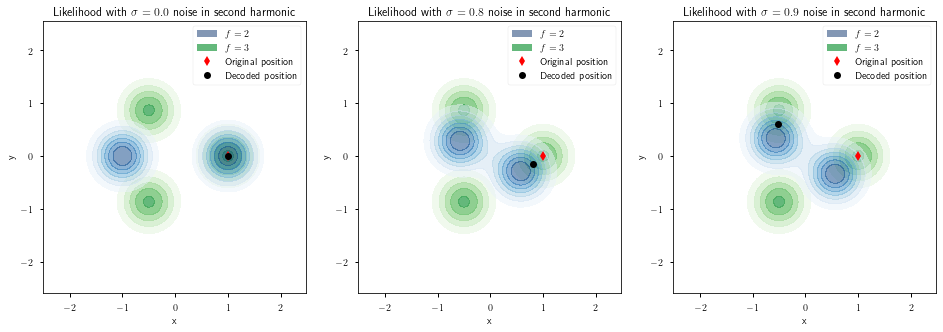

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))

a0 = r0 * activity(theta0, [2,3], True)

for noise, ax in zip([0.0, 0.8, 0.9], axs):
	noise_vector = np.cos(2*2*np.pi*neuron_indices/N - 0.7)
	a = a0 - noise*noise_vector
	f2_L = likelihood_distribution(2)(a)
	f3_L = likelihood_distribution(3)(a)
	decode_x, decode_y = decode_likelihood_xy(f2_L * f3_L)
	plt.sca(ax)
	# plot_likelihood_distribution(f2_L)
	# plot_likelihood_distribution(f2_L + f3_L)
	c3 = plt.contourf(grid_x, grid_y, f3_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f2_L.max(), 8), extend='max')
	c2 = plt.contourf(grid_x, grid_y, f2_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f2_L.max(), 8), extend='max')
	r2 = plt.Rectangle((0, 0), 1, 1, fc=c2.tcolors[np.count_nonzero(c2.levels <= f2_L.max()) - 1][0], label='$f=2$')
	r3 = plt.Rectangle((0, 0), 1, 1, fc=c3.tcolors[np.count_nonzero(c3.levels <= f3_L.max()) - 1][0], label='$f=3$')
	plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
	plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.legend(handles=[r2, r3] + ax.patches + ax.lines)
	plt.title(f'Likelihood with $\\sigma={noise}$ noise in second harmonic')
	plt.axis('equal')
# plt.tight_layout()
plt.show()

### Worst case noise for combinations of harmonics

In [3]:
decoding_error = lambda x0, y0, decode_x, decode_y : np.sqrt((decode_x - x0)**2 + (decode_y - y0)**2)
joint_likelihood = lambda fs, a: likelihood_distribution(fs[0])(a) * likelihood_distribution(fs[1])(a) if len(fs) > 1 else likelihood_distribution(fs[0])(a)
fs_to_label = lambda fs: f'$f={fs[0]}$ and $f={fs[1]}$'if len(fs) > 1 else f'$f={fs[0]}$'
# scale noise with number of harmonics (encoded signal energy)
noise_low_harmonic = lambda fs, noise_ratio, noise_angle: np.sqrt(len(fs))*noise_ratio*np.cos(2*fs[0]*np.pi*neuron_indices/N - noise_angle)
noise_high_harmonic = lambda fs, noise_ratio, noise_angle: np.sqrt(len(fs))*noise_ratio*np.cos(2*fs[1]*np.pi*neuron_indices/N - noise_angle) if len(fs)>1 else noise_low_harmonic(fs, noise_ratio, noise_angle)
noise_both_harmonics = lambda fs, noise_ratio, noise_angle: noise_ratio*np.cos(2*fs[0]*np.pi*neuron_indices/N - noise_angle) + noise_ratio*np.cos(2*fs[1]*np.pi*neuron_indices/N - noise_angle) if len(fs)>1 else noise_low_harmonic(fs, noise_ratio, noise_angle)


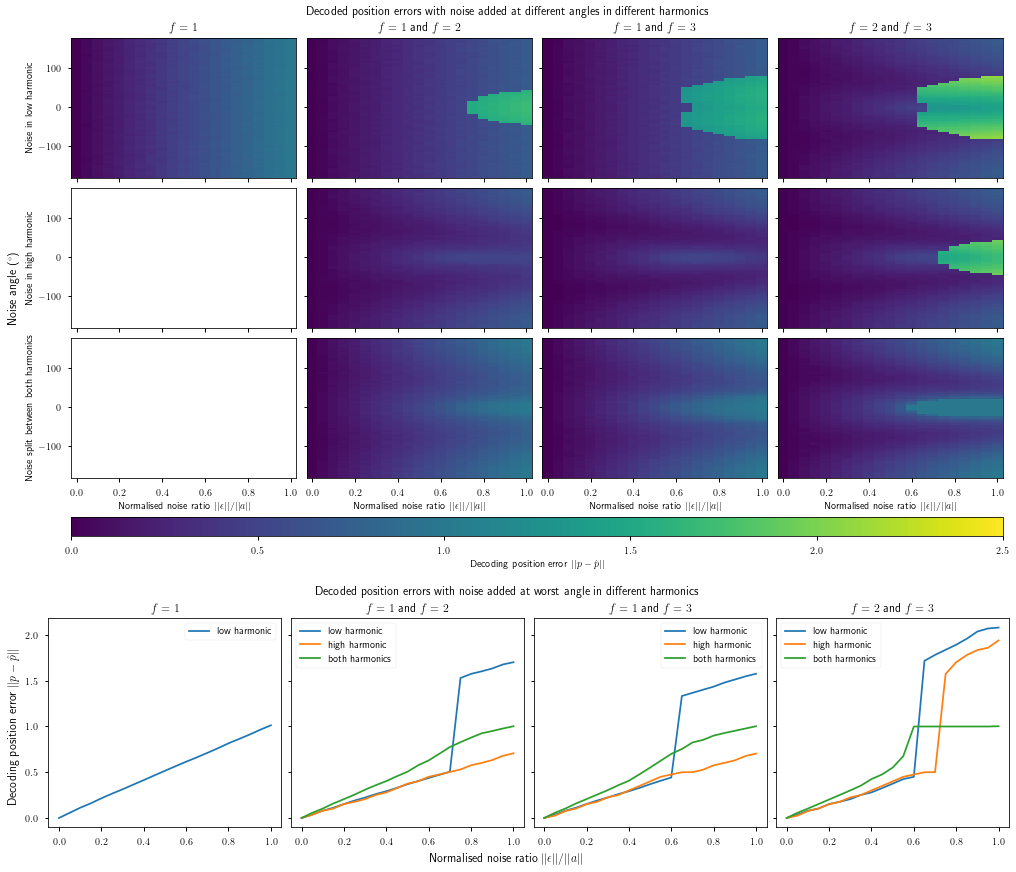

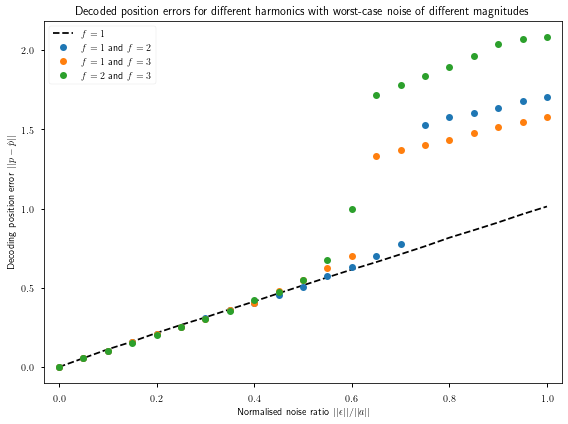

In [8]:
x0, y0 = r0*np.cos(theta0), r0*np.sin(theta0)

noise_angle_range = np.linspace(-np.pi, np.pi, 50) 
noise_range_position = np.arange(0, 1.02, 0.05)

fig1 = plt.figure(constrained_layout=True, figsize=(14,12))
subfigs = fig1.subfigures(2, 1, hspace=0.03, height_ratios=[2, 1])
img_grid = subfigs[0].subplots(3,4,sharex=True, sharey=True)
error_axs = subfigs[1].subplots(1,4,sharey=True)
fig2, ax1 = plt.subplots(1,1)

f_combinations = [[1], [1,2], [1,3], [2,3]]
all_position_errors = []

for ax_col, error_ax, fs in zip(img_grid.T, error_axs, f_combinations):
	a0 = r0 * activity(theta0, fs, True)
	position_errors = np.zeros((len(noise_angle_range), len(noise_range_position), 3))
	for n, (ax, noise_function) in enumerate(zip(ax_col, [noise_low_harmonic,noise_high_harmonic,noise_both_harmonics] if len(fs) > 1 else [noise_low_harmonic])):
		for i, noise_angle in enumerate(noise_angle_range):
			for j, noise_ratio in enumerate(noise_range_position):
				noise = noise_function(fs, noise_ratio, noise_angle)
				assert np.allclose(np.sqrt(np.sum(noise**2)) / np.sqrt(np.sum(a0**2)), noise_ratio) # else we didn't add the noise correctly
				position_errors[i,j,n] = decoding_error(x0, y0, *decode_likelihood_xy(joint_likelihood(fs, a0 - noise)))
		im = ax.pcolor(noise_range_position, np.degrees(noise_angle_range), position_errors[:,:,n], vmin=0, vmax=2.5)
		ax.ylim(-182,182)
		error_ax.plot(noise_range_position, np.max(position_errors[:,:,n], axis=0), label=['low harmonic','high harmonic','both harmonics'][n])
	all_position_errors.append(position_errors)
	
	ax_col[0].set_title(f'{fs_to_label(fs)}')
	error_ax.set_title(f'{fs_to_label(fs)}')
	error_ax.legend()

	ax1.plot(noise_range_position, np.max(np.max(position_errors, axis=2), axis=0), 'o' if len(fs) == 2 else 'k--', label=fs_to_label(fs))

subfigs[0].colorbar(im, ax=img_grid, location='bottom', pad=0.01, aspect=50).set_label('Decoding position error $||p - \\hat p||$')
for ax, title in zip(img_grid[:,0], ['in low harmonic', 'in high harmonic', 'split between both harmonics']):
	ax.set_ylabel(f'Noise {title}')
for ax in img_grid[2,:]:
	ax.set_xlabel('Normalised noise ratio $||\\epsilon|| / ||a||$')
subfigs[0].supylabel('Noise angle (${}^\\circ$)')
subfigs[1].supylabel('Decoding position error $||p - \\hat p||$')
subfigs[1].supxlabel('Normalised noise ratio $||\\epsilon|| / ||a||$')

subfigs[0].suptitle('Decoded position errors with noise added at different angles in different harmonics')
subfigs[1].suptitle('Decoded position errors with noise added at worst angle in different harmonics')

ax1.legend()
ax1.set_xlim(-0.03,1.03)
ax1.set_title('Decoded position errors for different harmonics with worst-case noise of different magnitudes')
ax1.set_ylabel('Decoding position error $||p - \\hat p||$')
ax1.set_xlabel('Normalised noise ratio $||\\epsilon|| / ||a||$')
fig2.tight_layout()

plt.show()

## Heading decoding

In the case of heading decoding we assume that the circuit dynamics operate on a significantly faster timescale than the slow accumulation of noise, such that magnitude of the activity in the network is constant. Noise therefore can rotate activity bumps around the network.

As explained above, higher harmonics are less sensitive to angular noise.

When we have two harmonics used for encoding, the total signal energy is twice that for a signal harmonic. Twice the amount of noise can be used to keep the signal to noise ratio the same. This can be distributed into each of the harmonics

$$\begin{aligned}
	\epsilon &= \epsilon_{f_1} + \epsilon_{f_2} \\
	\|\epsilon\|^2 &= 2 \\
	\|\epsilon_{f_1}\|^2 + \|\epsilon_{f_2}\|^2 &= 2
\end{aligned}$$

The angular error is inversely proportional to the harmonic

$$\begin{aligned}
	\Delta\theta_{f_1} &= \frac{\|\epsilon_{f_1}\|}{f_1} \\
	\Delta\theta_{f_2} &= \frac{\|\epsilon_{f_2}\|}{f_2} \\
\end{aligned}$$

And the total angular error is the average of the error contributions from each of the harmonics

$$\begin{aligned}
	\Delta\theta &= \frac{\Delta\theta_{f_1} + \Delta\theta_{f_2}}{2} \\
	&= \frac{\frac{\|\epsilon_{f_1}\|}{f_1} + \frac{\|\epsilon_{f_2}\|}{f_2}}{2} \\
	&= \frac{f_2 \|\epsilon_{f_1}\| + f_1 \|\epsilon_{f_2}\|}{2 f_1 f_2} \\
	&= \frac{f_2 \|\epsilon_{f_1}\| + f_1 \sqrt{2 - \|\epsilon_{f_1}\|^2}}{2 f_1 f_2}
\end{aligned}$$

To find the maximum, set the derivative to 0

$$\begin{aligned}
	\frac{d\Delta\theta}{d\|\epsilon_{f_1}\|} &= \frac{1}{2 f_1 f_2} \left(f_2 + \frac{f_1}{\sqrt{2 - \|\epsilon_{f_1}\|^2}} \cdot \frac{1}{2} \cdot -2\|\epsilon_{f_1}\|\right) \\
	0 &= \frac{1}{2 f_1 f_2} \left(f_2 - \frac{f_1\|\epsilon_{f_1}\|}{\sqrt{2 - \|\epsilon_{f_1}\|^2}} \right) \\
	f_2 &= \frac{f_1\|\epsilon_{f_1}\|}{\sqrt{2 - \|\epsilon_{f_1}\|^2}} \\
	f_2 \sqrt{2 - \|\epsilon_{f_1}\|^2} &= f_1\|\epsilon_{f_1}\| \\
	f_2^2 (2 - \|\epsilon_{f_1}\|^2) &= f_1^2\|\epsilon_{f_1}\|^2 \\ 
	2 f_2^2 &= (f_2^2 + f_1^2) \|\epsilon_{f_1}\|^2 \\ 
	\|\epsilon_{f_1}\|^2 &= \frac{2 f_2^2}{f_2^2 + f_1^2} \\ 
\end{aligned}$$

Calculating this for the combinations of harmonics we are considering

$$\begin{aligned}
	f&=1,2:\quad & \|\epsilon_{f_1}\|^2 &= \frac{8}{5} \quad & \Delta\theta &= 0.7906 \\
	f&=1,3:\quad & \|\epsilon_{f_1}\|^2 &= \frac{9}{5} \quad & \Delta\theta &= 0.7454 \\
	f&=2,3:\quad & \|\epsilon_{f_2}\|^2 &= \frac{18}{12} \quad & \Delta\theta &= 0.4249 \\
\end{aligned}$$

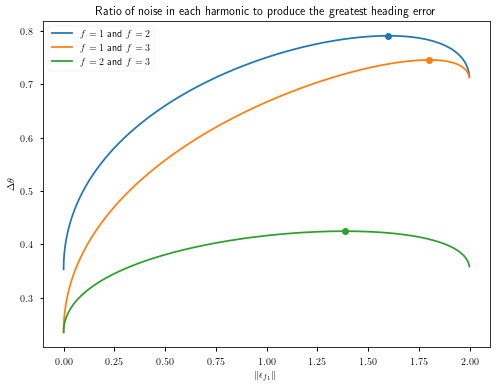

In [42]:
x2 = np.arange(0,2,0.001)
for n, fs in enumerate([[1,2],[1,3],[2,3]]):
    max_x2 = (2*fs[1]**2) / (fs[1]**2 + fs[0]**2)
    plt.plot(x2, (fs[1]*np.sqrt(x2) + fs[0]*np.sqrt(2 - x2)) / (2*fs[0]*fs[1]), f'C{n}', label=f'$f={fs[0]}$ and $f={fs[1]}$')
    plt.plot(max_x2, (fs[1]*np.sqrt(max_x2) + fs[0]*np.sqrt(2 - max_x2)) / (2*fs[0]*fs[1]), f'C{n}o')

plt.xlabel('$\\|\\epsilon_{f_1}\\|$')
plt.ylabel('$\\Delta\\theta$')
plt.title('Ratio of noise in each harmonic to produce the greatest heading error')
plt.legend()
plt.show()

As in the position encoding case, the decoding will experience significant heading errors when the lower harmonic bump is affected by noise such that it moves closer to the wrong bump for the higher harmonic.


### $f=1$ and $f=2$

For $f=1$ and $f=2$ the bumps are $180^\circ = \frac{\pi}{2}~\text{rad}$ apart so the decoding will choose the wrong bump if 

$$\begin{aligned}
	\sqrt{2}\|\epsilon_{f_1}\| &> \frac{\pi}{2} \\
	\|\epsilon_{f_1}\| &> \frac{\pi}{2\sqrt{2}} \\
	&= 1.1107
\end{aligned}$$

C:\Users\Dominic\AppData\Local\Temp\ipykernel_3548\1237007109.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  print(f'f1-{decode_likelihood_theta(f1_L):.3f}, f2-{decode_likelihood_theta(f2_L):.3f}, joint-{decode_likelihood_theta(f1_L*f2_L):.3f}, rate={decode_likelihood_theta(f1_L*f2_L)/noise:.3f}')


f1--0.000, f2--3.142, joint--0.000, rate=-inf
f1--1.546, f2--0.000, joint--0.785, rate=-0.714
f1--1.695, f2--0.000, joint--2.404, rate=-2.003
f1--0.644, f2-2.989, joint--0.395, rate=-0.790


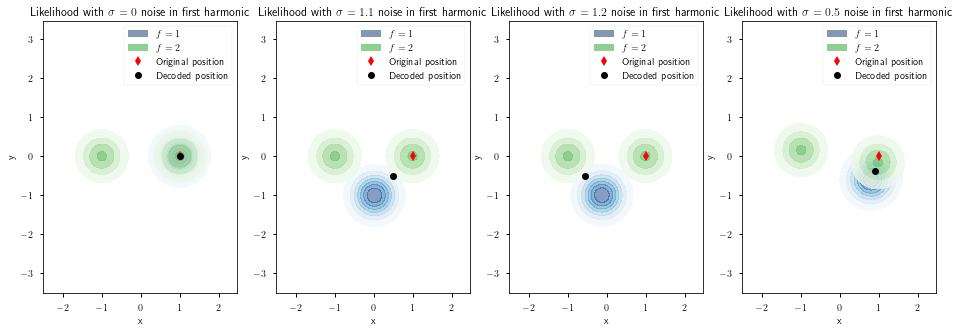

In [47]:
def worst_case_noise_ratio(fs):
	x2 = np.arange(0, 2, 0.001)
	return x2[np.argmax(1/(2*fs[0]*fs[1])*(fs[1]*np.sqrt(x2) + fs[0]*np.sqrt(2 - x2)))]

def apply_heading_noise(a0, fs, noise_mag, noise_in_harmonics, step=0.01):
	assert noise_in_harmonics in ['low','high','both']
	add_noise_step = [
		lambda a: a - step * np.sqrt(len(fs)) * np.cos(2*fs[0]*np.pi*neuron_indices/N - fs[0]*first_angle_decoder(fs[0])(a) - np.radians(90)),
		lambda a: a - step * np.sqrt(len(fs)) * np.cos(2*fs[1]*np.pi*neuron_indices/N - fs[1]*first_angle_decoder(fs[1])(a) - np.radians(90)),
		lambda a: a - step * (np.sqrt(worst_case_noise_ratio(fs))*np.cos(2*fs[0]*np.pi*neuron_indices/N - fs[0]*first_angle_decoder(fs[0])(a) - np.radians(90)) + (np.sqrt(2-worst_case_noise_ratio(fs)))*np.cos(2*fs[1]*np.pi*neuron_indices/N - fs[1]*first_angle_decoder(fs[1])(a) - np.radians(90)))
	][['low','high','both'].index(noise_in_harmonics) if len(fs) > 1 else 0]

	a = a0.copy()
	for _ in np.arange(0, noise_mag, step):
		a = add_noise_step(a)
		a /= np.sum(a**2) / np.sum(a0**2)
	return a

fig, axs = plt.subplots(1, 4, figsize=(16,5))

r0=1.0
a0 = r0 * activity(0, [1,2], True)

for noise, ax, type in zip([0, 1.1, 1.2, 0.5], axs, ['low','low','low','both']):
	a = apply_heading_noise(a0, [1,2], r0*noise, type)
	f1_L = likelihood_distribution(1)(a)
	f2_L = likelihood_distribution(2)(a)
	decode_x, decode_y = decode_likelihood_xy(f1_L*f2_L)
	plt.sca(ax)
	# plot_likelihood_distribution(f1_L + f2_L)
	c1 = plt.contourf(grid_x, grid_y, f1_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	c2 = plt.contourf(grid_x, grid_y, f2_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	r1 = plt.Rectangle((0, 0), 1, 1, fc=c1.tcolors[np.count_nonzero(c1.levels <= f1_L.max()) - 1][0], label='$f=1$')
	r2 = plt.Rectangle((0, 0), 1, 1, fc=c2.tcolors[np.count_nonzero(c2.levels <= f2_L.max()) - 1][0], label='$f=2$')
	plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
	plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
	print(f'f1-{decode_likelihood_theta(f1_L):.3f}, f2-{decode_likelihood_theta(f2_L):.3f}, joint-{decode_likelihood_theta(f1_L*f2_L):.3f}, rate={decode_likelihood_theta(f1_L*f2_L)/noise:.3f}')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.legend(handles=[r1, r2] + ax.patches + ax.lines)
	plt.title(f'Likelihood with $\\sigma={noise}$ noise in first harmonic')
	plt.axis('equal')
# plt.tight_layout()
plt.show()

### $f=1$ and $f=3$

For $f=1$ and $f=3$ the bumps are $120^\circ = \frac{\pi}{3}~\text{rad}$ apart so the decoding will choose the wrong bump if 

$$\begin{aligned}
	\sqrt{2}\|\epsilon_{f_1}\| &> \frac{\pi}{3} \\
	\|\epsilon_{f_1}\| &> \frac{\pi}{3\sqrt{2}} \\
	&= 0.7405
\end{aligned}$$

C:\Users\Dominic\AppData\Local\Temp\ipykernel_3548\2851681554.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  print(f'f1-{float(first_angle_decoder(1)(a)):.3f}, f3-{float(first_angle_decoder(3)(a)):.3f}, joint-{decode_likelihood_theta(f1_L*f3_L):.3f}, rate={decode_likelihood_theta(f1_L*f3_L)/noise:.3f}')


f1--0.000, f3-0.000, joint--0.000, rate=-inf
f1--0.990, f3-0.000, joint--0.502, rate=-0.717
f1--1.131, f3-0.000, joint--1.599, rate=-1.999
f1--0.671, f3--0.075, joint--0.371, rate=-0.742


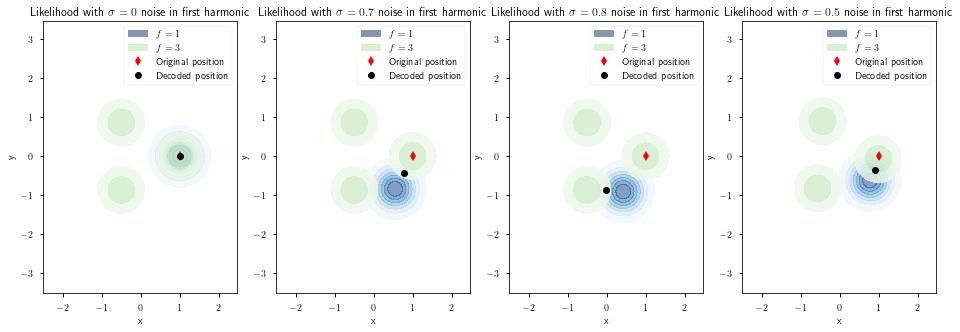

In [43]:
def worst_case_noise_ratio(fs):
	x2 = np.arange(0, 2, 0.001)
	return x2[np.argmax(1/(2*fs[0]*fs[1])*(fs[1]*np.sqrt(x2) + fs[0]*np.sqrt(2 - x2)))]

def apply_heading_noise(a0, fs, noise_mag, noise_in_harmonics, step=0.002):
	assert noise_in_harmonics in ['low','high','both']
	add_noise_step = [
		lambda a: a - step * np.sqrt(len(fs)) * np.cos(2*fs[0]*np.pi*neuron_indices/N - fs[0]*first_angle_decoder(fs[0])(a) - np.radians(90)),
		lambda a: a - step * np.sqrt(len(fs)) * np.cos(2*fs[1]*np.pi*neuron_indices/N - fs[1]*first_angle_decoder(fs[1])(a) - np.radians(90)),
		lambda a: a - step * (np.sqrt(worst_case_noise_ratio(fs))*np.cos(2*fs[0]*np.pi*neuron_indices/N - fs[0]*first_angle_decoder(fs[0])(a) - np.radians(90)) + (np.sqrt(2-worst_case_noise_ratio(fs)))*np.cos(2*fs[1]*np.pi*neuron_indices/N - fs[1]*first_angle_decoder(fs[1])(a) - np.radians(90)))
	][['low','high','both'].index(noise_in_harmonics) if len(fs) > 1 else 0]

	a = a0.copy()
	for _ in np.arange(0, noise_mag, step):
		a = add_noise_step(a)
		a /= np.sum(a**2) / np.sum(a0**2)
	return a

fig, axs = plt.subplots(1, 4, figsize=(16,5))
r0=1
a0 = r0 * activity(0, [1,3], True)

for noise, ax, type in zip([0, 0.7, 0.8, 0.5], axs, ['low','low','low','both']):
	a = apply_heading_noise(a0, [1,3], r0*noise, type)
	f1_L = likelihood_distribution(1)(a)
	f3_L = likelihood_distribution(3)(a)
	decode_x, decode_y = decode_likelihood_xy(f1_L*f3_L)
	plt.sca(ax)
	# plot_likelihood_distribution(f1_L + f3_L)
	c1 = plt.contourf(grid_x, grid_y, f1_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	c3 = plt.contourf(grid_x, grid_y, f3_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	r1 = plt.Rectangle((0, 0), 1, 1, fc=c1.tcolors[np.count_nonzero(c1.levels <= f1_L.max()) - 1][0], label='$f=1$')
	r3 = plt.Rectangle((0, 0), 1, 1, fc=c3.tcolors[np.count_nonzero(c3.levels <= f3_L.max()) - 1][0], label='$f=3$')
	plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
	plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
	
	print(f'f1-{float(first_angle_decoder(1)(a)):.3f}, f3-{float(first_angle_decoder(3)(a)):.3f}, joint-{decode_likelihood_theta(f1_L*f3_L):.3f}, rate={decode_likelihood_theta(f1_L*f3_L)/noise:.3f}')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.legend(handles=[r1, r3] + ax.patches + ax.lines)
	plt.title(f'Likelihood with $\\sigma={noise}$ noise in first harmonic')
	plt.axis('equal')
# plt.tight_layout()
plt.show()

### $f=2$ and $f=3$

For $f=1$ and $f=3$ the bumps are $60^\circ = \frac{\pi}{6}~\text{rad}$ apart, but the angular error is halved when noise is added to the second harmonic, so the decoding will choose the wrong bump if 

$$\begin{aligned}
	\sqrt{2}\frac{\|\epsilon_{f_2}\|}{2} &> \frac{\pi}{6} \\
	\|\epsilon_{f_2}\| &> \frac{\pi}{3\sqrt{2}} \\
	&= 0.7405
\end{aligned}$$

C:\Users\Dominic\AppData\Local\Temp\ipykernel_3548\3488191073.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  print(f'f2-{float(first_angle_decoder(2)(a)):.3f}, f3-{float(first_angle_decoder(3)(a)):.3f}, joint-{decode_likelihood_theta(f2_L*f3_L):.3f}, rate={decode_likelihood_theta(f2_L*f3_L)/noise:.3f}')


f2--0.000, f3-0.000, joint--0.000, rate=-inf
f2--0.495, f3-0.000, joint--0.257, rate=-0.368
f2--0.565, f3-0.000, joint-2.338, rate=2.923
f2--0.294, f3--0.131, joint--0.202, rate=-0.405


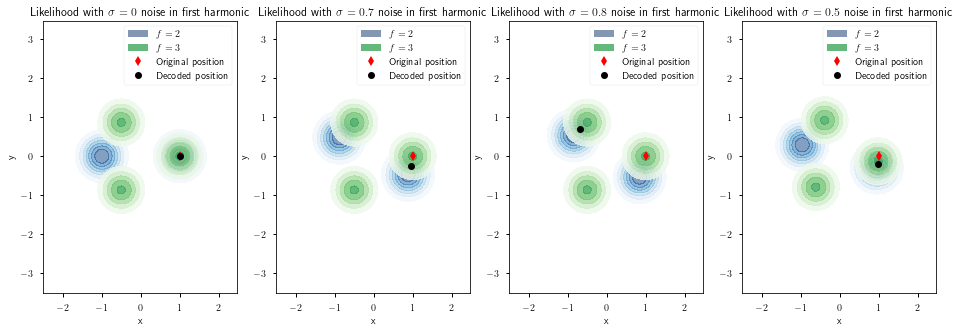

In [44]:
def worst_case_noise_ratio(fs):
	x2 = np.arange(0, 2, 0.001)
	return x2[np.argmax(1/(2*fs[0]*fs[1])*(fs[1]*np.sqrt(x2) + fs[0]*np.sqrt(2 - x2)))]

def apply_heading_noise(a0, fs, noise_mag, noise_in_harmonics, step=0.002):
	assert noise_in_harmonics in ['low','high','both']
	add_noise_step = [
		lambda a: a - step * np.sqrt(len(fs)) * np.cos(2*fs[0]*np.pi*neuron_indices/N - fs[0]*first_angle_decoder(fs[0])(a) - np.radians(90)),
		lambda a: a - step * np.sqrt(len(fs)) * np.cos(2*fs[1]*np.pi*neuron_indices/N - fs[1]*first_angle_decoder(fs[1])(a) - np.radians(90)),
		lambda a: a - step * (np.sqrt(worst_case_noise_ratio(fs))*np.cos(2*fs[0]*np.pi*neuron_indices/N - fs[0]*first_angle_decoder(fs[0])(a) - np.radians(90)) + (np.sqrt(2-worst_case_noise_ratio(fs)))*np.cos(2*fs[1]*np.pi*neuron_indices/N - fs[1]*first_angle_decoder(fs[1])(a) - np.radians(90)))
	][['low','high','both'].index(noise_in_harmonics) if len(fs) > 1 else 0]

	a = a0.copy()
	for _ in np.arange(0, noise_mag, step):
		a = add_noise_step(a)
		a /= np.sum(a**2) / np.sum(a0**2)
	return a

fig, axs = plt.subplots(1, 4, figsize=(16,5))
r0=1
a0 = r0 * activity(0, [2,3], True)

for noise, ax, type in zip([0, 0.7, 0.8, 0.5], axs, ['low','low','low','both']):
	a = apply_heading_noise(a0, [2,3], r0*noise, type)
	f2_L = likelihood_distribution(2)(a)
	f3_L = likelihood_distribution(3)(a)
	decode_x, decode_y = decode_likelihood_xy(f2_L*f3_L)
	plt.sca(ax)
	# plot_likelihood_distribution(f2_L + f3_L)
	c2 = plt.contourf(grid_x, grid_y, f2_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f2_L.max(), 8), extend='max')
	c3 = plt.contourf(grid_x, grid_y, f3_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f2_L.max(), 8), extend='max')
	r2 = plt.Rectangle((0, 0), 1, 1, fc=c2.tcolors[np.count_nonzero(c2.levels <= f2_L.max()) - 1][0], label='$f=2$')
	r3 = plt.Rectangle((0, 0), 1, 1, fc=c3.tcolors[np.count_nonzero(c3.levels <= f3_L.max()) - 1][0], label='$f=3$')
	plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
	plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
	
	print(f'f2-{float(first_angle_decoder(2)(a)):.3f}, f3-{float(first_angle_decoder(3)(a)):.3f}, joint-{decode_likelihood_theta(f2_L*f3_L):.3f}, rate={decode_likelihood_theta(f2_L*f3_L)/noise:.3f}')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.legend(handles=[r2, r3] + ax.patches + ax.lines)
	plt.title(f'Likelihood with $\\sigma={noise}$ noise in first harmonic')
	plt.axis('equal')
# plt.tight_layout()
plt.show()

### Checking worst case noise

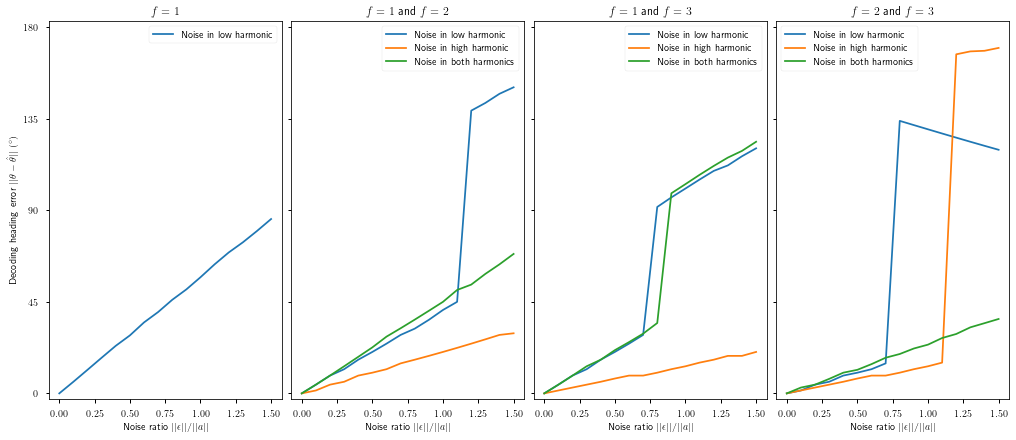

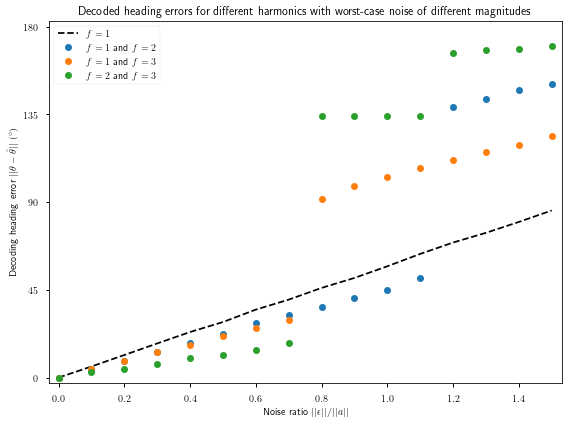

In [5]:
decoding_error_heading = lambda theta0, decode_theta : abs(theta0 - decode_theta)

def worst_case_noise_ratio(fs):
	x2 = np.arange(0, 2, 0.001)
	return x2[np.argmax(1/(2*fs[0]*fs[1])*(fs[1]*np.sqrt(x2) + fs[0]*np.sqrt(2 - x2)))]

def apply_heading_noise(a0, fs, noise_mag, noise_in_harmonics, step=0.002):
	assert noise_in_harmonics in ['low','high','both']
	add_noise_step = [
		lambda a: a - step * np.sqrt(len(fs)) * np.cos(2*fs[0]*np.pi*neuron_indices/N - fs[0]*first_angle_decoder(fs[0])(a) - np.radians(90)),
		lambda a: a - step * np.sqrt(len(fs)) * np.cos(2*fs[1]*np.pi*neuron_indices/N - fs[1]*first_angle_decoder(fs[1])(a) - np.radians(90)),
		lambda a: a - step * (np.sqrt(worst_case_noise_ratio(fs))*np.cos(2*fs[0]*np.pi*neuron_indices/N - fs[0]*first_angle_decoder(fs[0])(a) - np.radians(90)) + (np.sqrt(2-worst_case_noise_ratio(fs)))*np.cos(2*fs[1]*np.pi*neuron_indices/N - fs[1]*first_angle_decoder(fs[1])(a) - np.radians(90)))
	][['low','high','both'].index(noise_in_harmonics) if len(fs) > 1 else 0]

	a = a0.copy()
	for _ in np.arange(0, noise_mag, step):
		a = add_noise_step(a)
		a /= np.sum(a**2) / np.sum(a0**2)
	return a

noise_range_heading = np.arange(0, 1.52, 0.1)

fig1, error_axs = plt.subplots(1, 4, sharey=True, constrained_layout=True, figsize=(14,6))
fig2, ax1 = plt.subplots(1,1)

f_combinations = [[1], [1,2], [1,3], [2,3]]
all_heading_errors = []

theta0 = 0
r0 = 1

for error_ax, fs in zip(error_axs, f_combinations):
	a0 = r0 * activity(theta0, fs, True)
	heading_errors = np.zeros((len(noise_range_heading), 3))
	for n, noise_type in enumerate(['low','high','both'] if len(fs) > 1 else ['low']):
		for j, noise_ratio in enumerate(noise_range_heading):
			heading_errors[j,n] = decoding_error_heading(theta0, decode_likelihood_theta(joint_likelihood(fs, apply_heading_noise(a0, fs, noise_ratio, noise_type))))
		error_ax.plot(noise_range_heading, np.degrees(heading_errors[:,n]), label=['Noise in low harmonic','Noise in high harmonic','Noise in both harmonics'][n])
	all_heading_errors.append(heading_errors)
	
	error_ax.set_title(f'{fs_to_label(fs)}')
	error_ax.set_xlabel('Noise ratio $||\\epsilon|| / ||a||$')
	error_ax.legend()

	ax1.plot(noise_range_heading, np.degrees(np.max(np.maximum.accumulate(heading_errors, axis=0), axis=1)), 'o' if len(fs) == 2 else 'k--', label=fs_to_label(fs))

error_axs[0].set_ylabel('Decoding heading error $||\\theta - \\hat \\theta||$ $({}^\\circ)$')
error_axs[0].set_yticks(np.linspace(0,180,5))
error_axs[0].set_ylim(-3,183)

ax1.legend()
ax1.set_xlim(-0.03,1.53)
ax1.set_ylim(-3,183)
ax1.set_yticks(np.linspace(0,180,5))
ax1.set_title('Decoded heading errors for different harmonics with worst-case noise of different magnitudes')
ax1.set_ylabel('Decoding heading error $||\\theta - \\hat \\theta||$ $({}^\\circ)$')
ax1.set_xlabel('Noise ratio $||\\epsilon|| / ||a||$')
fig2.tight_layout()

plt.show()

## Plotting everything together

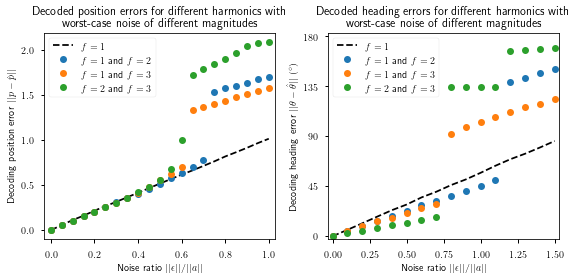

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

for fs, position_errors, heading_errors in zip(f_combinations, all_position_errors, all_heading_errors):
	ax1.plot(noise_range_position, np.max(np.max(position_errors, axis=2), axis=0), 'o' if len(fs) == 2 else 'k--', label=fs_to_label(fs))
	ax2.plot(noise_range_heading, np.degrees(np.max(np.maximum.accumulate(heading_errors, axis=0), axis=1)), 'o' if len(fs) == 2 else 'k--', label=fs_to_label(fs))

ax1.legend()
ax1.set_xlim(-0.03,1.03)
ax1.set_title('Decoded position errors for different harmonics with\nworst-case noise of different magnitudes')
ax1.set_ylabel('Decoding position error $||p - \\hat p||$')
ax1.set_xlabel('Noise ratio $||\\epsilon|| / ||a||$')

ax2.legend()
ax2.set_xlim(-0.03,1.53)
ax2.set_ylim(-3,183)
ax2.set_yticks(np.linspace(0,180,5))
ax2.set_title('Decoded heading errors for different harmonics with\nworst-case noise of different magnitudes')
ax2.set_ylabel('Decoding heading error $||\\theta - \\hat \\theta||$ $({}^\\circ)$')
ax2.set_xlabel('Noise ratio $||\\epsilon|| / ||a||$')

plt.tight_layout()
plt.savefig('plots/combined-harmonics-worst-case-error.pdf')
plt.show()

## Mean error with random Gaussian noise

The average noise energy is the expectation of the root mean square of a Gaussian sample for each neuron

$$\|\epsilon\| = \mathbb{E}\left[\sqrt{\frac{1}{N} \sum^N \mathcal{N}(0,\sigma^2)^2}\right]$$

For small $N$ this isn't equal to the variance. For example, for $N=1$ we have

$$\|\epsilon\| = \mathbb{E}\left[|\mathcal{N}(0,\sigma^2)|\right]$$

which is the mean of a [folded normal distribution](https://en.wikipedia.org/wiki/Folded_normal_distribution), so

$$\|\epsilon\| = \sqrt{\frac{2}{\pi}}$$

For higher $N$ we just compute numerical approximations and use this to set the noise ratio $\frac{\|\epsilon\|}{\|a\|}$

In [ ]:
def mean_variance_discrete_gaussian_sample(n: int):
	return np.mean(np.sqrt(np.mean(np.random.randn(n,10000000)**2, axis=0)))

for n in range(1,9):
	print(f'{n} - {mean_variance_discrete_gaussian_sample(n)}')

1 - 0.7978210933935467
2 - 0.8859145755004512
3 - 0.9211904407062125
4 - 0.939977641753459
5 - 0.9513855630368853
6 - 0.9594136095636117
7 - 0.9650347061297482
8 - 0.969231822382148


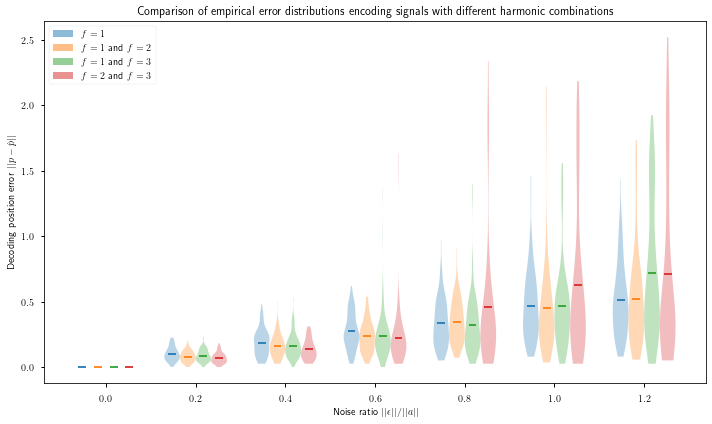

In [ ]:
corrupt_activity = lambda a0, noise_sigma: a0 + noise_sigma*np.random.randn(*a0.shape)

noise_mag_range = np.arange(0, 1.4, 0.2)
x0, y0 = r0*np.cos(theta0), r0*np.sin(theta0)

violin_spacing = 0.035
violin_width = 0.035

for fs,plot_offset in zip([[1], [1,2], [1,3], [2,3]], np.linspace(-3/2,3/2,4)*violin_spacing):
	a0 = r0 * activity(theta0, fs, True)
	# the mean noise energy with 1/0.969*noise_sigma * np.random.randn(8) = noise_sigma^2
	# the mean signal energy is np.sqrt(len(fs))*np.sqrt(2)/2
	# signal_energy = np.sqrt(np.mean(a0**2))
	# avg_noise_energy = np.mean([np.sqrt(np.mean(corrupt_activity(np.zeros_like(a0), 1/0.969*np.sqrt(len(fs))*np.sqrt(2)/2)**2)) for _ in range(10000)])
	# print(f'{avg_noise_energy:.3f}/{signal_energy:.3f}={avg_noise_energy/signal_energy:.3f}')
	plt.violinplot([[decoding_error(x0, y0, *decode_likelihood_xy(joint_likelihood(fs, corrupt_activity(a0, 1/0.969*np.sqrt(len(fs))*np.sqrt(2)/2*noise_mag)))) for _ in range(100)] for noise_mag in noise_mag_range], noise_mag_range+plot_offset, widths=violin_width, showextrema=False, showmeans=True)

plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, alpha=0.5, fc=f'C{n}', label=fs_to_label(fs)) for n, fs in enumerate([[1], [1,2], [1,3], [2,3]])], loc='upper left')

plt.ylabel('Decoding position error $||p - \\hat p||$')
plt.xlabel('Noise ratio $||\\epsilon|| / ||a||$')
plt.title('Comparison of empirical error distributions encoding signals with different harmonic combinations')
plt.tight_layout()
plt.show()

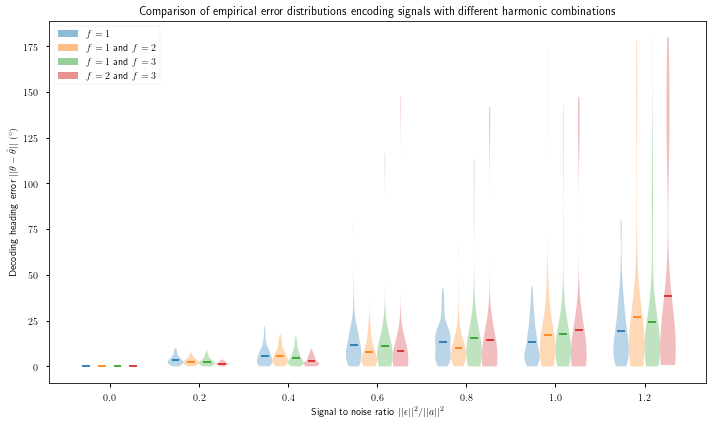

In [ ]:
for fs,plot_offset in zip([[1], [1,2], [1,3], [2,3]], np.linspace(-3/2,3/2,4)*violin_spacing):
	a0 = r0 * activity(theta0, fs, True)
	# the mean noise energy with 1/0.969*noise_sigma * np.random.randn(8) = noise_sigma^2
	# the mean signal energy is np.sqrt(len(fs))*np.sqrt(2)/2
	# signal_energy = np.sqrt(np.mean(a0**2))
	# avg_noise_energy = np.mean([np.sqrt(np.mean(corrupt_activity(np.zeros_like(a0), 1/0.969*np.sqrt(len(fs))*np.sqrt(2)/2)**2)) for _ in range(10000)])
	# print(f'{avg_noise_energy:.3f}/{signal_energy:.3f}={avg_noise_energy/signal_energy:.3f}')
	plt.violinplot([[np.degrees(decoding_error_heading(theta0, decode_likelihood_theta(joint_likelihood(fs, corrupt_activity(a0, 1/0.969*np.sqrt(len(fs))*np.sqrt(2)/2*noise_mag))))) for _ in range(100)] for noise_mag in noise_mag_range], noise_mag_range+plot_offset, widths=violin_width, showextrema=False, showmeans=True)

plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, alpha=0.5, fc=f'C{n}', label=fs_to_label(fs)) for n, fs in enumerate([[1], [1,2], [1,3], [2,3]])], loc='upper left')

plt.ylabel('Decoding heading error $||\\theta - \\hat \\theta||$ $({}^\\circ)$')
plt.xlabel('Signal to noise ratio $||\\epsilon||^2 / ||a||^2$')
plt.title('Comparison of empirical error distributions encoding signals with different harmonic combinations')
plt.tight_layout()
plt.show()